In [65]:
import os, sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from wordcloud import WordCloud

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, GRU, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1_l2

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Preprocessing

In [2]:
import re, string
import pandas as pd

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

sw = stopwords.words('english')


def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


def lemmatization(data, lemmatizer):

    tokens = word_tokenize(data)
    tags = [nltk.tag.pos_tag([token]) for token in tokens]
    data = [lemmatizer.lemmatize(pair[0][0], pos=get_wordnet_pos(pair[0][1])) for pair in tags]
    return " ".join(data)


def get_contractions(path):

    contr_char = chr(39) # `
    text_char  = chr(96) # '

    df_contractions = pd.read_csv(path)
    for col_name in df_contractions.columns:
        df_contractions[col_name] = df_contractions[col_name].replace({contr_char: text_char}, regex=True).str.lower()
    df_contractions.set_index('Contraction', inplace=True)
    dict_contractions = df_contractions.to_dict()['Meaning']

    return dict_contractions


def rename_columns(col_name):

    # Removing the unnecessary additional info in column name
    new_name = re.findall("(.*)\s(?:-|\(|$)", str(col_name))
    if len(new_name):
        col_name = new_name[0]

    # For the textId column
    col_name = re.sub("([^\s])([A-Z])", r"\1_\2", col_name)
    # For all other columns
    col_name = re.sub("( [a-zA-Z])", r"_\1", col_name).lower().replace(" ", "")

    return col_name


def data_cleaning(data, dict_contractions=None):

    data = data.lower().strip()

    # replace contractions (i`ve -> i have, couldn`t -> could not etc.)
    if dict_contractions is not None:
        data_split = data.split(" ")
        for idx_word in range(len(data_split)):
            if data_split[idx_word].strip() in dict_contractions.keys():
                data_split[idx_word] = dict_contractions[data_split[idx_word].strip()]
        data = " ".join(data_split)

    # removing punctuation
    data = re.sub(re.compile("[" + re.escape(string.punctuation) + "]"), " ", data)

    # eliminate digits
    data = re.sub(r"\d+", "", data)

    # remove all single characters
    data = re.sub(r"\s+[a-zA-Z]\s+", " ", data)

    # substituting multiple blank spaces with only one
    data = re.sub(r"\s+", " ", data, flags=re.I)

    clean_text = []
    for word in data.split(" "):
      if word not in sw and word not in ['', 'http', 'lol', 'www', 'com'] and len(word) >= 3:
        clean_text.append(word)

    return " ".join(clean_text)


def preprocess_text(df, column_name, lemm=False, dict_contractions=None):

    lemmatizer = WordNetLemmatizer()
    df[column_name + "_preprocessed"] = df[column_name].apply(lambda text: data_cleaning(lemmatization(text, lemmatizer),
                                                                                         dict_contractions) \
                                                              if lemm else data_cleaning(text, dict_contractions))


def remove_nan_rows(df):
    return df.dropna(subset=['text_id'])

def read_process_data(path, preprocess_text_flg=False, lemm=False, contractions_path=None, remove_nan_flag=False):
    df = pd.read_csv(path, encoding="ISO-8859-1")
    df.columns = df.columns.map(rename_columns)

    if remove_nan_flag:
        df = remove_nan_rows(df)

    string_columns = ["text_id", "text", "selected_text", "country", "time_of_tweet", "age_of_user"]
    int_columns = ["population", "land_area", "density"]
    for str_col in string_columns:
        if str_col in df.columns:
            df[str_col] = df[str_col].astype('str')

    for int_col in int_columns:
        if int_col in df.columns:
            df[int_col] = pd.to_numeric(df[int_col])

    # create a new column text_preprocessed for the preprocessed text
    if preprocess_text_flg:
        dict_contractions = None
        if contractions_path is not None:
            dict_contractions = get_contractions(contractions_path)
        preprocess_text(df, "text", lemm, dict_contractions)

    return df

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# EDA

In [12]:
TRAIN_DATA_PATH = "/content/train.csv"
TEST_DATA_PATH = "/content/test.csv"


train_data = read_process_data(TRAIN_DATA_PATH,preprocess_text_flg=True, remove_nan_flag=True)
test_data = read_process_data(TEST_DATA_PATH, preprocess_text_flg=True, remove_nan_flag=True)

In [13]:
test_data

,text_id,text,sentiment,time_of_tweet,age_of_user,country,population,land_area,density,text_preprocessed
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0,last session day twitpic ezh
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,noon,21-30,Albania,2877797.0,27400.0,105.0,shanghai also really exciting precisely skyscr...
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,night,31-45,Algeria,43851044.0,2381740.0,18.0,recession hit veronique branquinho quit compan...
3,01082688c6,happy bday!,positive,morning,46-60,Andorra,77265.0,470.0,164.0,happy bday
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,noon,60-70,Angola,32866272.0,1246700.0,26.0,twitpic like
...,...,...,...,...,...,...,...,...,...,...
3529,e5f0e6ef4b,"its at 3 am, im very tired but i can`t sleep ...",negative,noon,21-30,Nicaragua,6624554.0,120340.0,55.0,tired sleep try
3530,416863ce47,All alone in this old house again. Thanks for...,positive,night,31-45,Niger,24206644.0,1266700.0,19.0,alone old house thanks net keeps alive kicking...
3531,6332da480c,I know what you mean. My little dog is sinkin...,negative,morning,46-60,Nigeria,206139589.0,910770.0,226.0,know mean little dog sinking depression wants ...
3532,df1baec676,_sutra what is your next youtube video gonna b...,positive,noon,60-70,North Korea,25778816.0,120410.0,214.0,sutra next youtube video gonna love videos


In [14]:
train_data.head()

,text_id,text,selected_text,sentiment,time_of_tweet,age_of_user,country,population,land_area,density,text_preprocessed
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60,responded going
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105,sooo sad miss san diego
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18,boss bullying
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164,interview leave alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26,sons put releases already bought


In [15]:
test_data.head()

,text_id,text,sentiment,time_of_tweet,age_of_user,country,population,land_area,density,text_preprocessed
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0,last session day twitpic ezh
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,noon,21-30,Albania,2877797.0,27400.0,105.0,shanghai also really exciting precisely skyscr...
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,night,31-45,Algeria,43851044.0,2381740.0,18.0,recession hit veronique branquinho quit compan...
3,01082688c6,happy bday!,positive,morning,46-60,Andorra,77265.0,470.0,164.0,happy bday
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,noon,60-70,Angola,32866272.0,1246700.0,26.0,twitpic like


In [16]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   text_id            27481 non-null  object 
 1   text               27481 non-null  object 
 2   selected_text      27481 non-null  object 
 3   sentiment          27481 non-null  object 
 4   time_of_tweet      27481 non-null  object 
 5   age_of_user        27481 non-null  object 
 6   country            27481 non-null  object 
 7   population         27481 non-null  int64  
 8   land_area          27481 non-null  float64
 9   density            27481 non-null  int64  
 10  text_preprocessed  27481 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 2.3+ MB


In [17]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3534 entries, 0 to 3533
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   text_id            3534 non-null   object 
 1   text               3534 non-null   object 
 2   sentiment          3534 non-null   object 
 3   time_of_tweet      3534 non-null   object 
 4   age_of_user        3534 non-null   object 
 5   country            3534 non-null   object 
 6   population         3534 non-null   float64
 7   land_area          3534 non-null   float64
 8   density            3534 non-null   float64
 9   text_preprocessed  3534 non-null   object 
dtypes: float64(3), object(7)
memory usage: 303.7+ KB


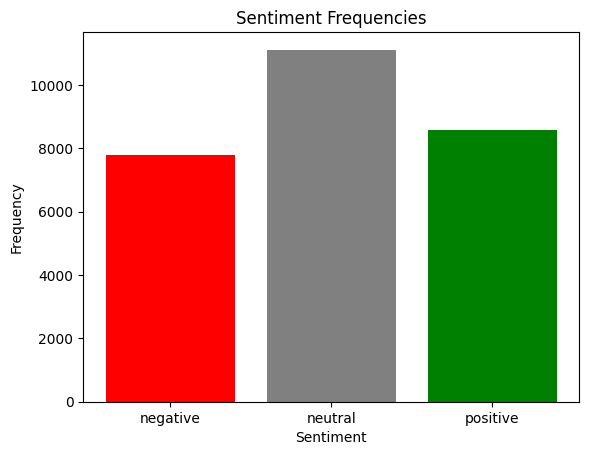

In [18]:
sentiment_frequencies = train_data.sentiment.value_counts().sort_index().to_dict()

sentiments = list(sentiment_frequencies.keys())
frequencies = list(sentiment_frequencies.values())

plt.bar(sentiments, frequencies, color=["red", "gray", "green"])
plt.xlabel("Sentiment")
plt.ylabel("Frequency")
plt.title("Sentiment Frequencies")
plt.show()

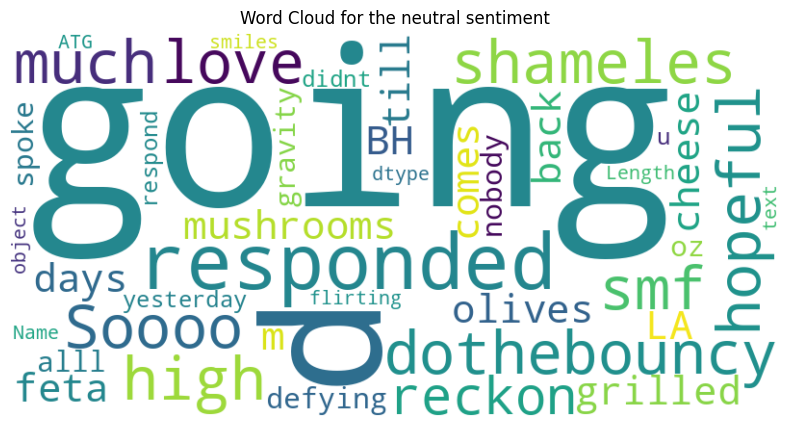

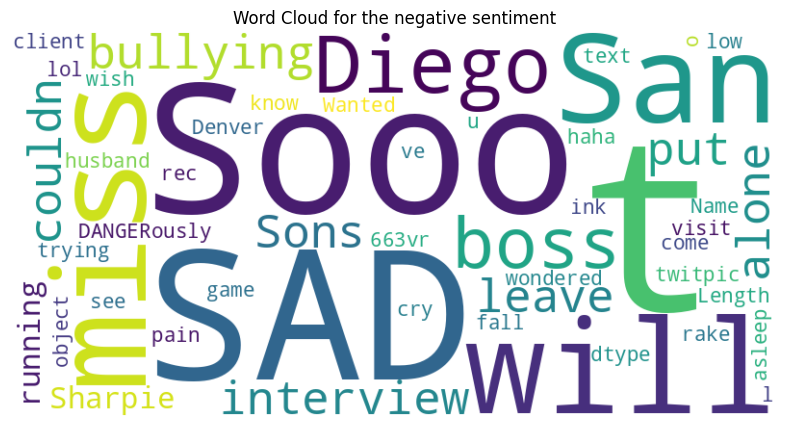

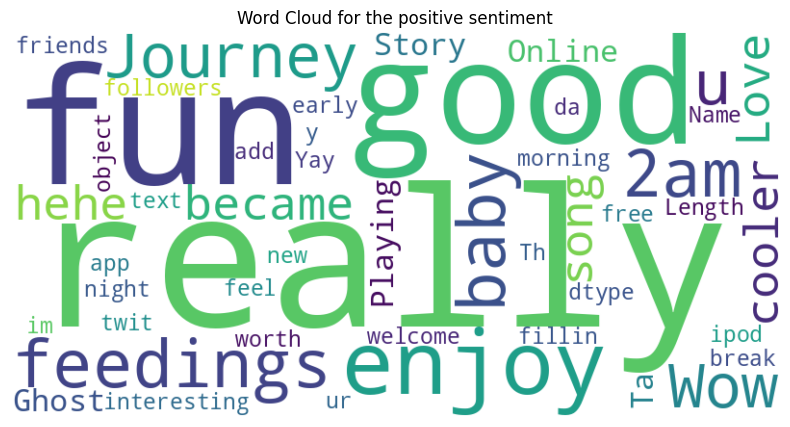

In [19]:
def generate_wordcloud(data, title):
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(str(data))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

# Unique sentiment values
sentiments = train_data["sentiment"].unique()

# Generate a word cloud for each sentiment
for sentiment in sentiments:
    sentiment_data = train_data[train_data["sentiment"] == sentiment]["text"]
    generate_wordcloud(sentiment_data, f"Word Cloud for the {sentiment} sentiment")

<ipython-input-20-5b238bbbbc05>:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


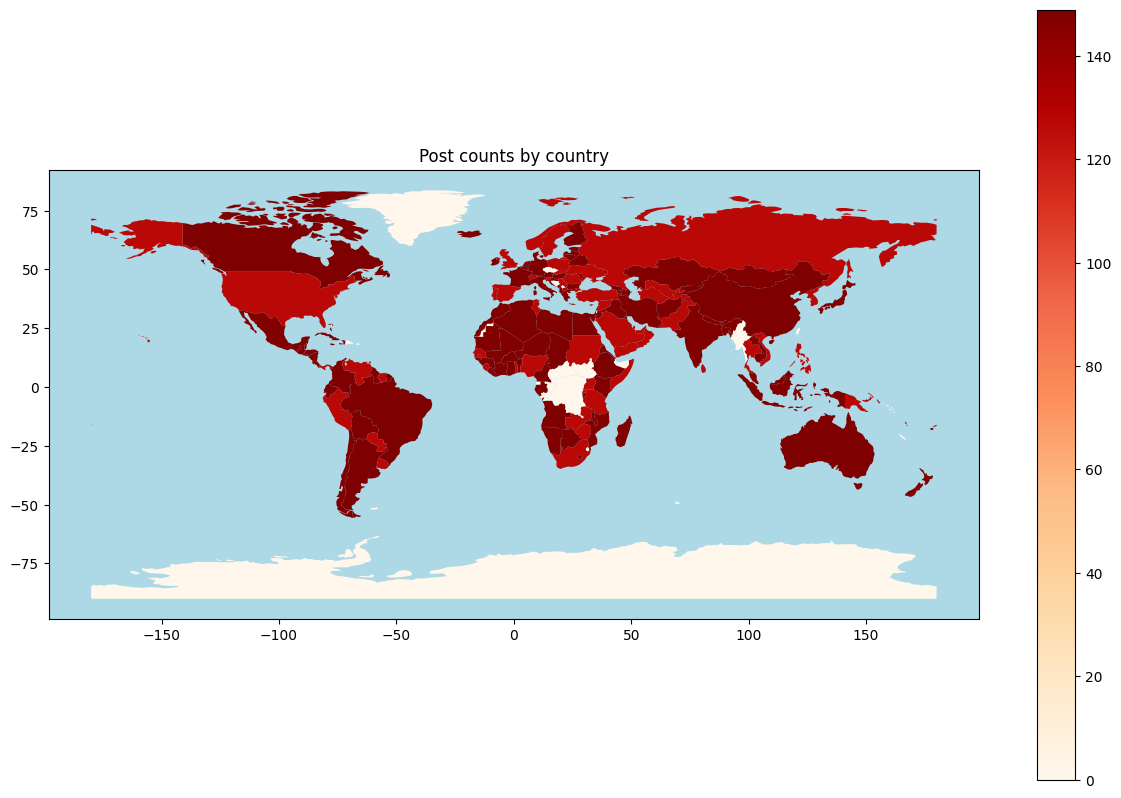

In [20]:
country_counts = train_data.country.value_counts().reset_index()

country_counts.columns = ["country", "count"]
# country_counts
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.merge(country_counts, left_on="name", right_on="country", how="left")
world["count"] = world["count"].fillna(0)


fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.set_facecolor("lightblue")
world.plot(column="count", ax=ax, legend=True, cmap="OrRd")
plt.title("Post counts by country")
plt.show()

# NN Preprocessing

In [28]:
train_texts = train_data['text_preprocessed'].values
test_texts = test_data['text_preprocessed'].values

In [29]:
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data['sentiment'].values)
test_labels = label_encoder.transform(test_data['sentiment'].values)
num_classes = np.max(train_labels) + 1

In [30]:
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

In [31]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)

num_words = len(tokenizer.word_index) + 1

In [32]:
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

In [33]:
max_length = max(len(x) for x in train_sequences)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding="post")
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding="post")

In [34]:
X_train, X_val, y_train, y_val = train_test_split(train_padded, train_labels, test_size=0.20, random_state=42)

# RNN

In [ ]:
model = Sequential()

model.add(Embedding(input_dim=num_words, output_dim=128, input_length=max_length))
model.add(SimpleRNN(128))
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
687/687 [==============================] - 41s 58ms/step - loss: 0.8843 - accuracy: 0.5832 - val_loss: 0.7763 - val_accuracy: 0.6702
Epoch 2/20
687/687 [==============================] - 39s 57ms/step - loss: 0.5726 - accuracy: 0.7757 - val_loss: 0.8099 - val_accuracy: 0.6647
Epoch 3/20
687/687 [==============================] - 39s 57ms/step - loss: 0.3313 - accuracy: 0.8826 - val_loss: 0.9837 - val_accuracy: 0.6414
Epoch 4/20
687/687 [==============================] - 39s 57ms/step - loss: 0.2168 - accuracy: 0.9261 - val_loss: 1.1056 - val_accuracy: 0.6216
Epoch 5/20
687/687 [==============================] - 39s 57ms/step - loss: 0.1592 - accuracy: 0.9472 - val_loss: 1.2494 - val_accuracy: 0.6211
Epoch 6/20
687/687 [==============================] - 39s 57ms/step - loss: 0.1384 - accuracy: 0.9556 - val_loss: 1.2921 - val_accuracy: 0.6227
Epoch 7/20
687/687 [==============================] - 39s 56ms/step - loss: 0.1147 - accuracy: 0.9629 - val_loss: 1.5262 - val_accuracy:

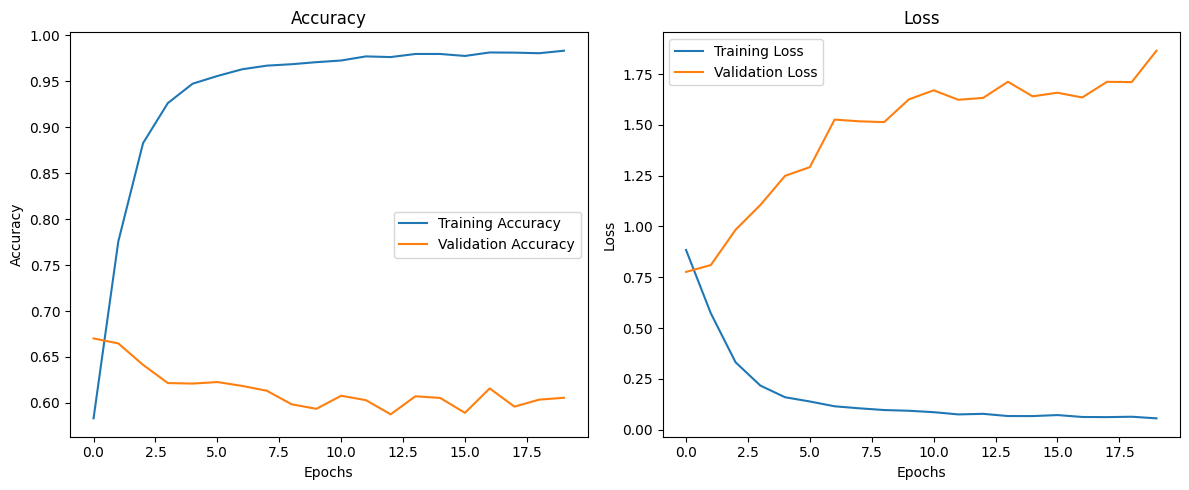

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_padded, test_labels)
print("Test Accuracy:", accuracy)

111/111 [==============================] - 1s 5ms/step - loss: 1.8803 - accuracy: 0.6013
Test Accuracy: 0.6013016700744629


In [ ]:
y_pred = model.predict(test_padded)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_labels, axis=1)

111/111 [==============================] - 1s 5ms/step


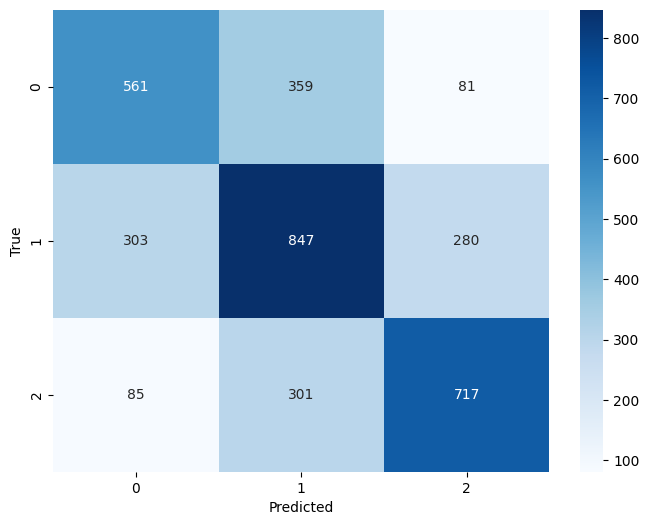

In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

Classification Report:
               precision    recall  f1-score   support

    negative       0.59      0.56      0.58      1001
     neutral       0.56      0.59      0.58      1430
    positive       0.67      0.65      0.66      1103

    accuracy                           0.60      3534
   macro avg       0.61      0.60      0.60      3534
weighted avg       0.60      0.60      0.60      3534



# GRU + dropout + early stopping

In [97]:
model = Sequential()

model.add(Embedding(input_dim=num_words, output_dim=128, input_length=max_length))
model.add(GRU(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_classes, activation='softmax'))

In [98]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [99]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [100]:
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/50
687/687 [==============================] - 97s 137ms/step - loss: 1.0885 - accuracy: 0.4030 - val_loss: 1.0864 - val_accuracy: 0.4057
Epoch 2/50
687/687 [==============================] - 75s 110ms/step - loss: 0.7813 - accuracy: 0.6588 - val_loss: 0.7222 - val_accuracy: 0.7126
Epoch 3/50
687/687 [==============================] - 73s 107ms/step - loss: 0.5568 - accuracy: 0.7849 - val_loss: 0.7250 - val_accuracy: 0.7075
Epoch 4/50
687/687 [==============================] - 74s 107ms/step - loss: 0.3747 - accuracy: 0.8634 - val_loss: 0.7695 - val_accuracy: 0.6967
Epoch 5/50
687/687 [==============================] - 73s 106ms/step - loss: 0.2619 - accuracy: 0.9088 - val_loss: 0.9691 - val_accuracy: 0.6780


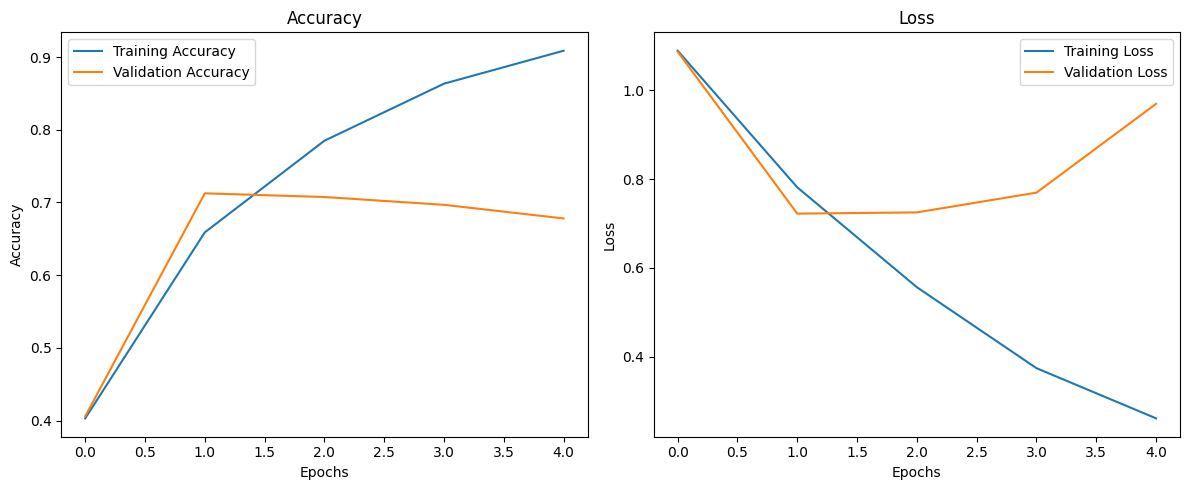

In [101]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [102]:
loss, accuracy = model.evaluate(test_padded, test_labels)
print("Test Accuracy:", accuracy)

111/111 [==============================] - 1s 8ms/step - loss: 0.9527 - accuracy: 0.6817
Test Accuracy: 0.6816638112068176


In [103]:
y_pred = model.predict(test_padded)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_labels, axis=1)

111/111 [==============================] - 1s 8ms/step


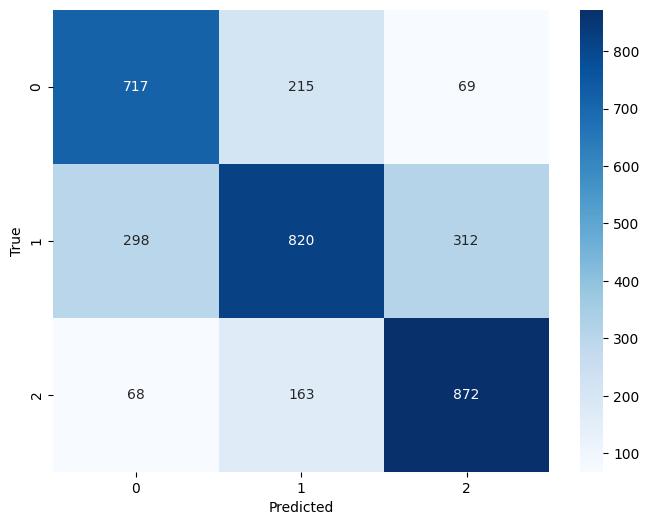

In [104]:
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [105]:
print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

Classification Report:
               precision    recall  f1-score   support

    negative       0.66      0.72      0.69      1001
     neutral       0.68      0.57      0.62      1430
    positive       0.70      0.79      0.74      1103

    accuracy                           0.68      3534
   macro avg       0.68      0.69      0.68      3534
weighted avg       0.68      0.68      0.68      3534



# 2 GRU Layers

The embedding dimension has been increased to 256. This allows the model to potentially capture more nuanced relationships between words.

The first GRU layer has return_sequences=True to ensure that the sequential output is passed to the next GRU layer.

In [39]:
model = Sequential()

model.add(Embedding(input_dim=num_words, output_dim=256, input_length=max_length))
model.add(GRU(128, return_sequences=True, dropout=0.2))
model.add(GRU(128, dropout=0.2))
model.add(Dense(num_classes, activation='softmax'))

In [40]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [42]:
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/50
687/687 [==============================] - 129s 175ms/step - loss: 0.9736 - accuracy: 0.5066 - val_loss: 0.7390 - val_accuracy: 0.6935
Epoch 2/50
687/687 [==============================] - 123s 179ms/step - loss: 0.6544 - accuracy: 0.7386 - val_loss: 0.6887 - val_accuracy: 0.7180
Epoch 3/50
687/687 [==============================] - 115s 168ms/step - loss: 0.4496 - accuracy: 0.8327 - val_loss: 0.7867 - val_accuracy: 0.7022
Epoch 4/50
687/687 [==============================] - 115s 167ms/step - loss: 0.2902 - accuracy: 0.8977 - val_loss: 0.9065 - val_accuracy: 0.6822
Epoch 5/50
687/687 [==============================] - 117s 170ms/step - loss: 0.2015 - accuracy: 0.9288 - val_loss: 1.0233 - val_accuracy: 0.6802


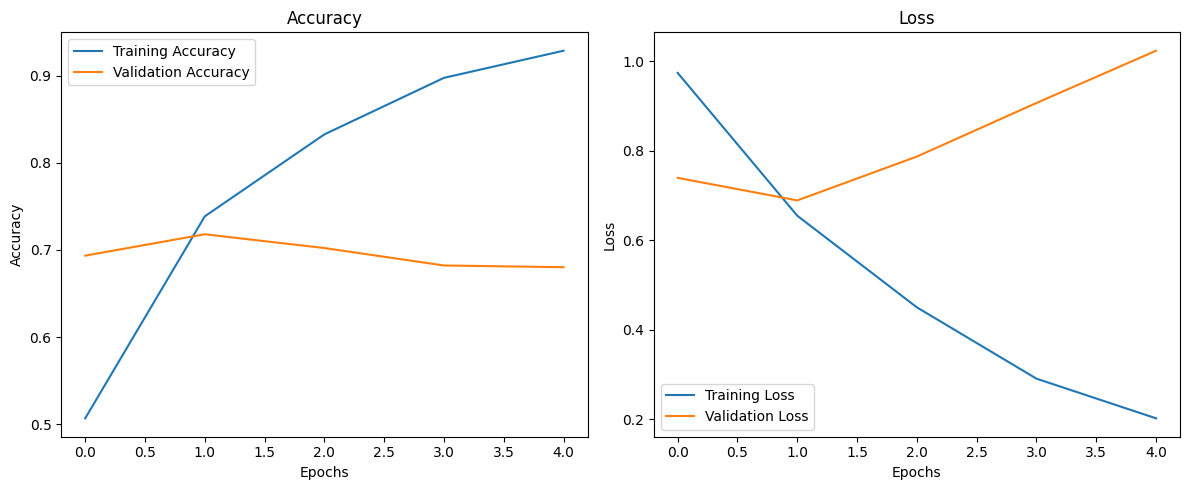

In [43]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [44]:
loss, accuracy = model.evaluate(test_padded, test_labels)
print("Test Accuracy:", accuracy)

111/111 [==============================] - 2s 21ms/step - loss: 0.9722 - accuracy: 0.6916
Test Accuracy: 0.691567599773407


In [45]:
y_pred = model.predict(test_padded)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_labels, axis=1)

111/111 [==============================] - 4s 20ms/step


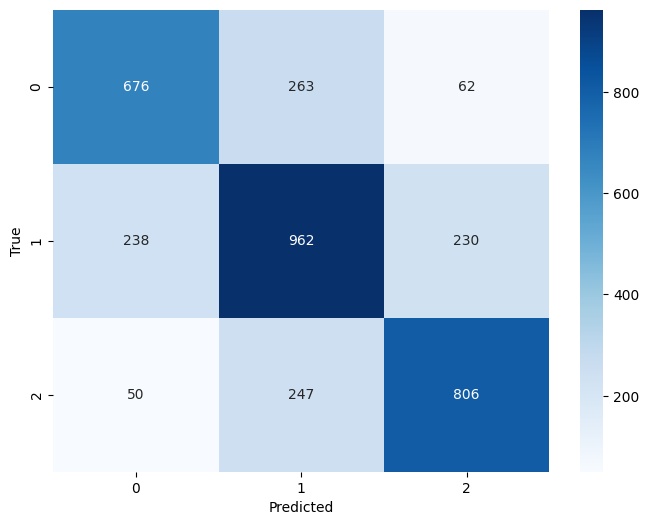

In [46]:
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [47]:
print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

Classification Report:
               precision    recall  f1-score   support

    negative       0.70      0.68      0.69      1001
     neutral       0.65      0.67      0.66      1430
    positive       0.73      0.73      0.73      1103

    accuracy                           0.69      3534
   macro avg       0.70      0.69      0.69      3534
weighted avg       0.69      0.69      0.69      3534



# 2 Bidirectional GRU Layers + GloVe 300 Word Embeddings

In [59]:
!gdown --id 1H_6pk6PV41pbIE17QwBcNt5Lqzv9RiH1

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1H_6pk6PV41pbIE17QwBcNt5Lqzv9RiH1
From (redirected): https://drive.google.com/uc?id=1H_6pk6PV41pbIE17QwBcNt5Lqzv9RiH1&confirm=t&uuid=b960b410-432d-46fd-9aa3-14e0b723f5c2
To: /content/glove.6B.300d.txt
100% 1.04G/1.04G [00:14<00:00, 70.1MB/s]


In [61]:
glove_embeddings = {}
embedding_dim = 300

with open('/content/glove.6B.300d.txt', 'r', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = coeffs

In [62]:
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i < num_words:
        embedding_vector = glove_embeddings.get(word)

        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [66]:
model = Sequential()

model.add(Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=max_length, weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(GRU(128)))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

In [67]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [68]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [69]:
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/50
687/687 [==============================] - 121s 166ms/step - loss: 0.7632 - accuracy: 0.6730 - val_loss: 0.7004 - val_accuracy: 0.7184
Epoch 2/50
687/687 [==============================] - 111s 162ms/step - loss: 0.6666 - accuracy: 0.7298 - val_loss: 0.6869 - val_accuracy: 0.7242
Epoch 3/50
687/687 [==============================] - 109s 158ms/step - loss: 0.6201 - accuracy: 0.7547 - val_loss: 0.6754 - val_accuracy: 0.7284
Epoch 4/50
687/687 [==============================] - 111s 161ms/step - loss: 0.5616 - accuracy: 0.7789 - val_loss: 0.7145 - val_accuracy: 0.7280
Epoch 5/50
687/687 [==============================] - 109s 159ms/step - loss: 0.4849 - accuracy: 0.8121 - val_loss: 0.7444 - val_accuracy: 0.7188
Epoch 6/50
687/687 [==============================] - 108s 158ms/step - loss: 0.3929 - accuracy: 0.8553 - val_loss: 0.8364 - val_accuracy: 0.7084


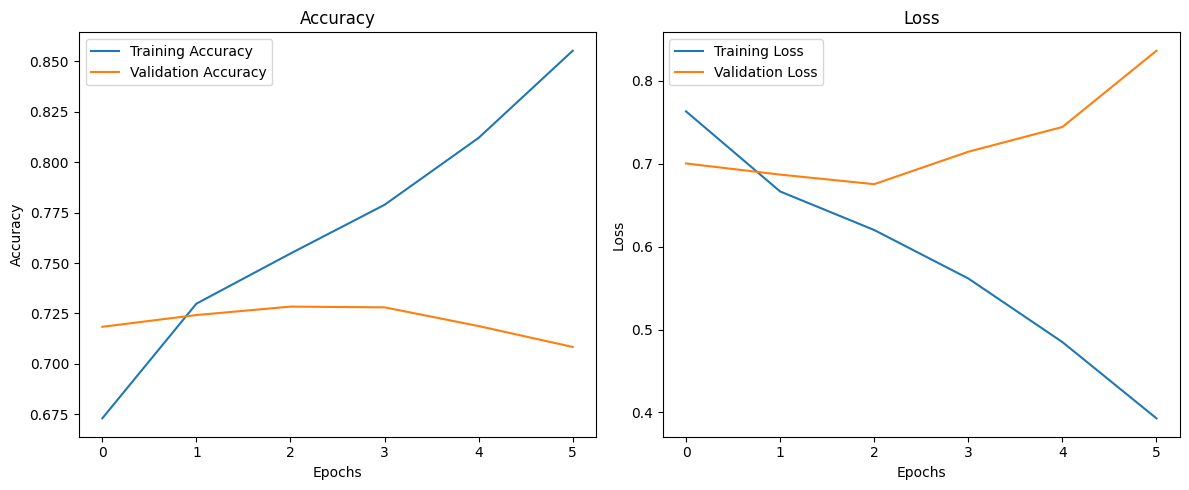

In [70]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [71]:
loss, accuracy = model.evaluate(test_padded, test_labels)
print("Test Accuracy:", accuracy)

111/111 [==============================] - 6s 56ms/step - loss: 0.8012 - accuracy: 0.7134
Test Accuracy: 0.7133559584617615


In [72]:
y_pred = model.predict(test_padded)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_labels, axis=1)

111/111 [==============================] - 6s 41ms/step


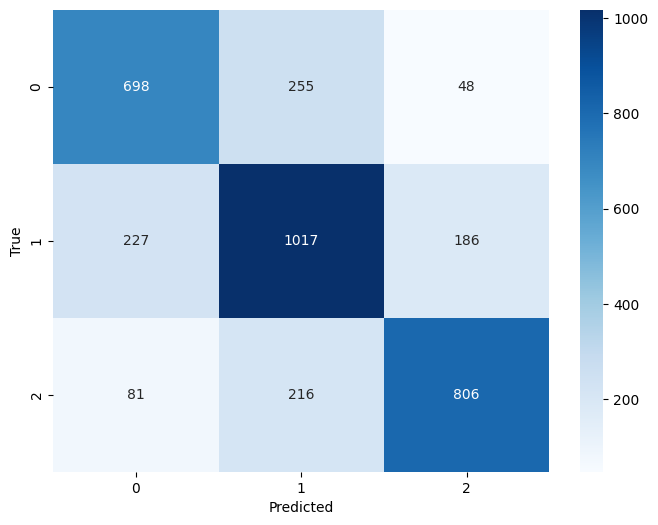

In [73]:
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [74]:
print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

Classification Report:
               precision    recall  f1-score   support

    negative       0.69      0.70      0.70      1001
     neutral       0.68      0.71      0.70      1430
    positive       0.78      0.73      0.75      1103

    accuracy                           0.71      3534
   macro avg       0.72      0.71      0.71      3534
weighted avg       0.71      0.71      0.71      3534

